# Read a Graph

First we load the image and do a Hough transform that only looks for horizontal and vertical lines.

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import IPython
import scipy.ndimage as ndimage
# try:
#     import Image
# except ImportError:
from PIL import Image
import pytesseract as tes

import sys
sys.path.insert(0, './functions')
import ocr_tools
import find_axes
from thresholding import adaptive_thresh

<IPython.core.display.Javascript object>


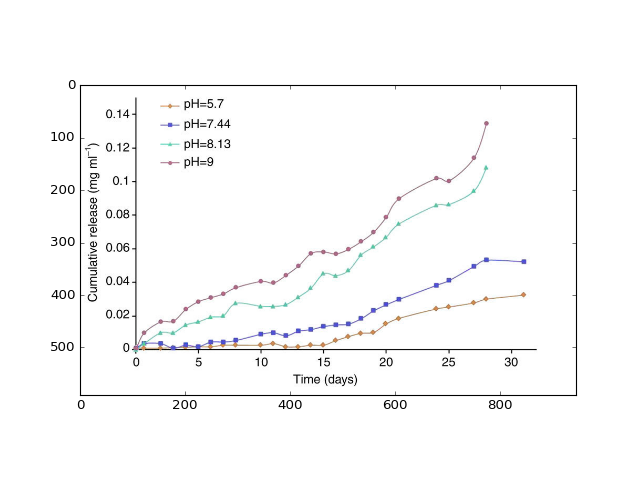

In [19]:
example = 'examples/example103.jpg'
img = cv2.imread(example)
m,n,p=img.shape

gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
# blur = cv2.GaussianBlur(img,(3,3),0)
# gray_blur = cv2.cvtColor(blur,cv2.COLOR_BGR2GRAY)
# r,bw = th3 = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
# ret2,bw2 = cv2.threshold(gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# ret3,bw3 = cv2.threshold(gray_blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
bw4 = adaptive_thresh(gray)
nbw = (255-bw4)

%matplotlib notebook

implot = plt.imshow(img)

In [44]:
text_id = img.copy()
contbw = np.copy(nbw)

# kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3 , 3)) # to manipulate the orientation of dilution , large x means horizonatally dilating  more, large y means vertically dilating more 
# dilated = cv2.dilate(contbw,kernel,iterations = 2) # dilate , more the iteration more the dilation

cnt, hierarchy = cv2.findContours(contbw,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE) # get contours

In [60]:
bound_rects = [cv2.boundingRect(c) for c in cnt]
aspect_ratios = [float(w)/h for x,y,w,h in bound_rects]
areas = [cv2.contourArea(c) for c in cnt]
rect_areas = [w*h for x,y,w,h in bound_rects]
extents = [float(a)/ra for a,ra in zip(areas,rect_areas)]
z=zip(range(len(areas)),aspect_ratios,rect_areas,extents)
text_inds = [i for i,ar,bb,ex in z if ar<1.3 and bb<400 and ex<0.6]
text_cnts = [cnt[i] for i in text_inds]

[array([[[513, 556]],
 
        [[512, 557]],
 
        [[511, 557]],
 
        [[510, 558]],
 
        [[510, 559]],
 
        [[510, 560]],
 
        [[510, 561]],
 
        [[511, 562]],
 
        [[512, 562]],
 
        [[513, 563]],
 
        [[514, 563]],
 
        [[515, 563]],
 
        [[516, 564]],
 
        [[517, 564]],
 
        [[518, 565]],
 
        [[517, 566]],
 
        [[516, 567]],
 
        [[515, 567]],
 
        [[514, 567]],
 
        [[513, 567]],
 
        [[512, 566]],
 
        [[511, 565]],
 
        [[510, 565]],
 
        [[510, 566]],
 
        [[510, 567]],
 
        [[511, 568]],
 
        [[512, 568]],
 
        [[513, 569]],
 
        [[514, 569]],
 
        [[515, 569]],
 
        [[516, 569]],
 
        [[517, 568]],
 
        [[518, 568]],
 
        [[519, 567]],
 
        [[519, 566]],
 
        [[519, 565]],
 
        [[519, 564]],
 
        [[519, 563]],
 
        [[518, 562]],
 
        [[517, 562]],
 
        [[516, 562]],
 
        [[515, 5

<IPython.core.display.Javascript object>


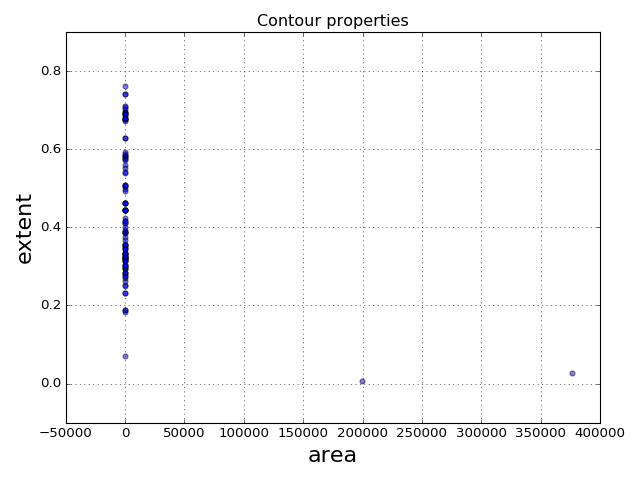

In [61]:
%matplotlib notebook
fig, ax = plt.subplots()
ax.scatter(rect_areas, extents, alpha=0.5)

ax.set_xlabel('area', fontsize=20)
ax.set_ylabel('extent', fontsize=20)
ax.set_title('Contour properties')
ax.grid(True)
fig.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


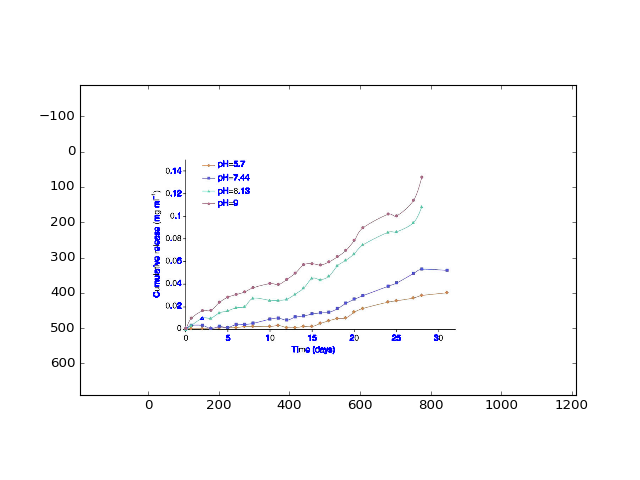

In [62]:
cv2.drawContours(text_id, text_cnts, -1, (0,0,255), 2)
%matplotlib notebook
plt.imshow(text_id)

In [ ]:
linesP = cv2.HoughLinesP(nbw,1,np.pi/2,2, minLineLength = nbw.shape[1]/10, maxLineGap = 3)[0]

<IPython.core.display.Javascript object>


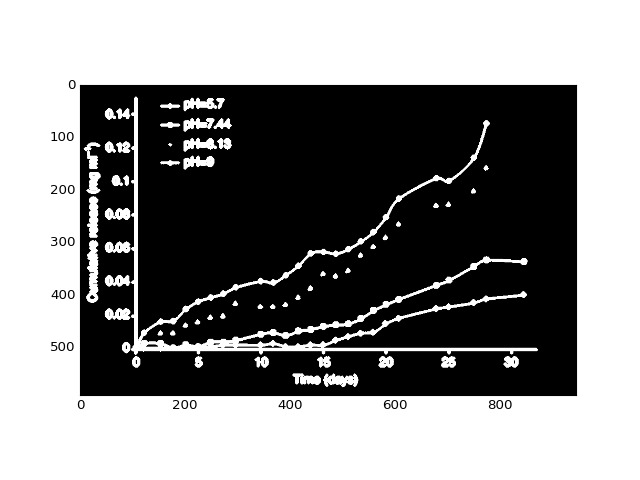

In [5]:
%matplotlib notebook
boxplot = plt.imshow(dilated)
boxplot.set_cmap('gray')

## Finding axes

Now we define the axis score, [cos^2, fractional length, fractional y-coord (or x coord for y axis)]

And we find the lines with the scores closest to these to be our x and y axes


In [24]:
import find_axes
# print(linesP)
xax = find_axes.get_xaxis(linesP,nbw)
print(xax)
yax = find_axes.get_yaxis(linesP,nbw)
print(yax)


[ 99 503 868 503]
[107 511 107  26]


<IPython.core.display.Javascript object>


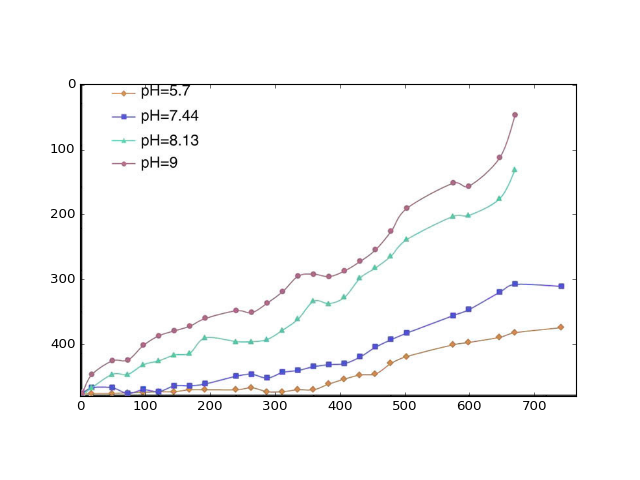

In [43]:
ROI = img[yax[3]:yax[1]-5,xax[0]+5:xax[2]+1]
cv2.imwrite('temp/ROI.png',ROI)
%matplotlib notebook
plt.imshow(ROI)

In [45]:
ROIocr = tes.image_to_string(Image.open('temp/ROI.png'),boxes=True)
print(ROIocr)

~ 0 0 749 480 0
~ 146 0 765 2 0


## Draw the axes

In [25]:
imlabel = img.copy();
cv2.line(imlabel,(xax[0],xax[1]),(xax[2],xax[3]),(255,0,0),2)
cv2.line(imlabel,(yax[0],yax[1]),(yax[2],yax[3]),(255,0,0),2)

<IPython.core.display.Javascript object>


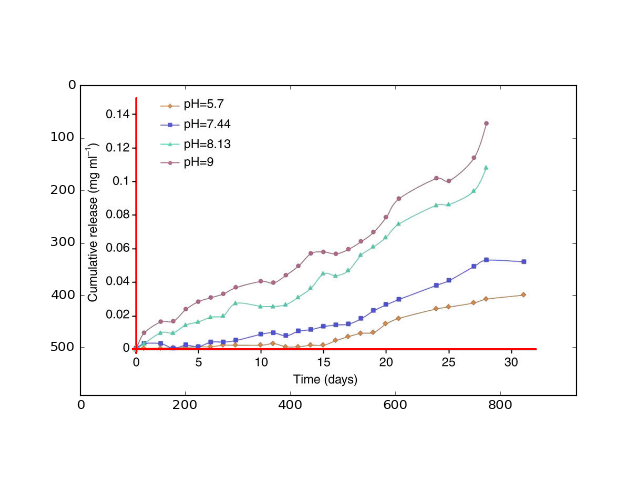

In [26]:
%matplotlib notebook

implot = plt.imshow(imlabel)
implot.set_cmap('gray')

## OCR to find Tick Labels

First we mask the image to read the text below the x-axis, removing the x-axis and its tick labels

<IPython.core.display.Javascript object>


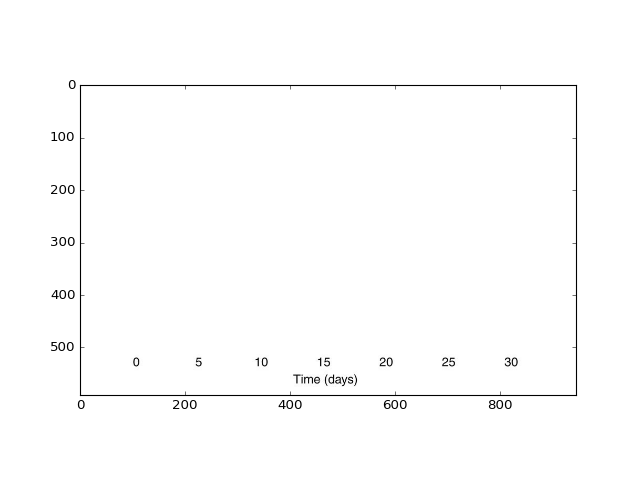

In [51]:
%matplotlib notebook

# Find where the x-ticks stop and crop the text image to be below that
below_xax_bw = np.zeros([m,n]).astype('uint8')
below_xax_bw[xax[1]:,:]=nbw[xax[1]:,:]
row_sums = below_xax_bw.sum(axis=1)
row_sums[0:xax[1]] = 1000
row_sums_list = row_sums.tolist()
text_crop_ind = row_sums_list.index(0)
text_crop_ind

xTextImg = np.ones([m,n,p]).astype('uint8')*255
xTextImg[text_crop_ind+1:,:,:]=img[text_crop_ind+1:,:,:]

cv2.imwrite('temp/xtext.png',xTextImg)
implot = plt.imshow(xTextImg)


In [53]:
xocr = tes.image_to_string(Image.open('temp/xtext.png'),boxes=True)

In [54]:
import ocr_tools

words = ocr_tools.clean_ocr_results(xocr)
words

[['10', 334, 54, 357, 71],
 ['15', 453, 54, 476, 71],
 ['Time', 406, 22, 457, 39],
 ['(days', 466, 17, 520, 39],
 [')', 522, 17, 527, 39],
 ['20', 570, 54, 595, 71],
 ['25', 689, 54, 714, 71],
 ['30', 809, 54, 833, 71]]

In [55]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

numbers = [w for w in words if is_number(w[0])]
for w in numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
xt_labels = np.array(numbers)
xt_labels

array([[  10.,  334.,  537.,  357.,  520.,  345.,  528.],
       [  15.,  453.,  537.,  476.,  520.,  464.,  528.],
       [  20.,  570.,  537.,  595.,  520.,  582.,  528.],
       [  25.,  689.,  537.,  714.,  520.,  701.,  528.],
       [  30.,  809.,  537.,  833.,  520.,  821.,  528.]])

<IPython.core.display.Javascript object>


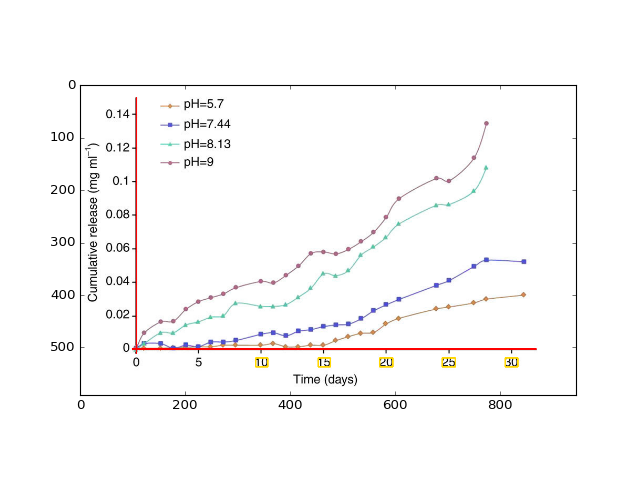

In [56]:
%matplotlib notebook

for w in numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Find X Ticks


## More Hough
transform on this image, looking only for vertical lines.

We then sort the results by x-coordinate and remove duplicates that are adjacent to each other by less than 5 pixels.

Finally we accept as ticks vertical lines that are separated from one another by the median spacing of all of the lines.

In [57]:
xt_dirty = find_axes.get_xticks(nbw,xax,tickMargin=11,minTickLen=0,maxGap=0)
xt_list=xt_dirty.tolist()

In [58]:
xt_match = find_axes.match_xticks(numbers,xt_list)
xt_pts = [xt_list[i] for i in xt_match]

<IPython.core.display.Javascript object>


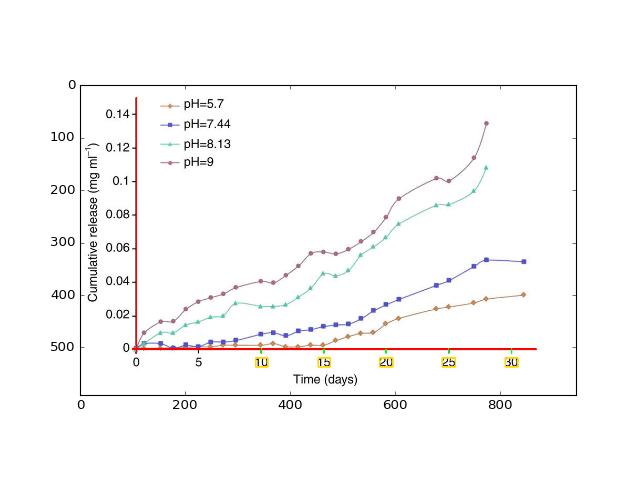

In [59]:
%matplotlib notebook
for x1,y1,x2,y2 in xt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [60]:
xt_pts_array = np.array(xt_pts)
xt_pts_array[:,0].reshape(-1,1)

array([[345],
       [464],
       [582],
       [701],
       [821]])

In [61]:
xt_labels[:,0].reshape(-1,1)

array([[ 10.],
       [ 15.],
       [ 20.],
       [ 25.],
       [ 30.]])

## The moment you've all been waiting for...

### Regress the tick labels against the tick pixel positions to calibrate the x-axis

In [62]:
from sklearn import datasets, linear_model
regrx = linear_model.LinearRegression(fit_intercept=True)

regrx.fit(xt_pts_array[:,0].reshape(-1,1), xt_labels[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regrx.coef_
print 'Intercept: \n', regrx.intercept_

Coefficients: 
[[ 0.04205182]]
Intercept: 
[-4.49938885]


## Now Get Y Ticks

In [63]:
# Find where the y-ticks stop and crop the text image to be left of that
left_yax_bw = np.zeros([m,n]).astype('uint8')
left_yax_bw[:yax[0],:]=nbw[:yax[0],:]
col_sums = left_yax_bw.sum(axis=0)
col_sums[yax[0]:] = 1000
col_zeros=np.where(col_sums==0)[0]
y_crop_ind=col_zeros[-1]

<IPython.core.display.Javascript object>


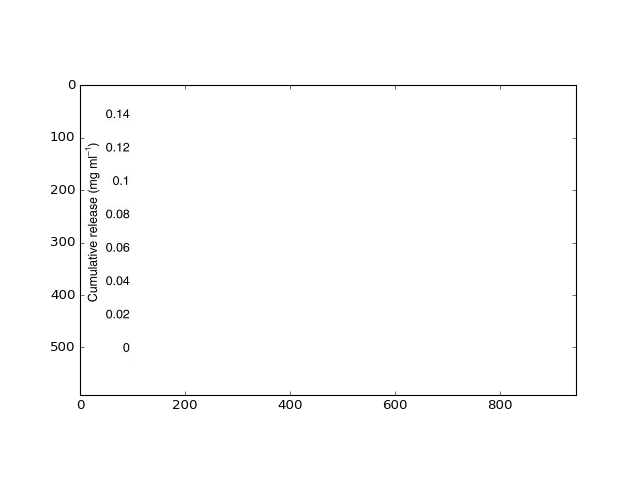

In [64]:
%matplotlib notebook
yTextImg = np.ones([m,n,p]).astype('uint8')*255
yTextImg[:,0:y_crop_ind-1,:]=img[:,0:y_crop_ind-1,:]

cv2.imwrite('temp/ytext.png',yTextImg)
implot = plt.imshow(yTextImg)

## Unfortunately

For OCR to work effectively on the y-axis, we must remove the rotated axis title completely. This is quite challenging.

<IPython.core.display.Javascript object>


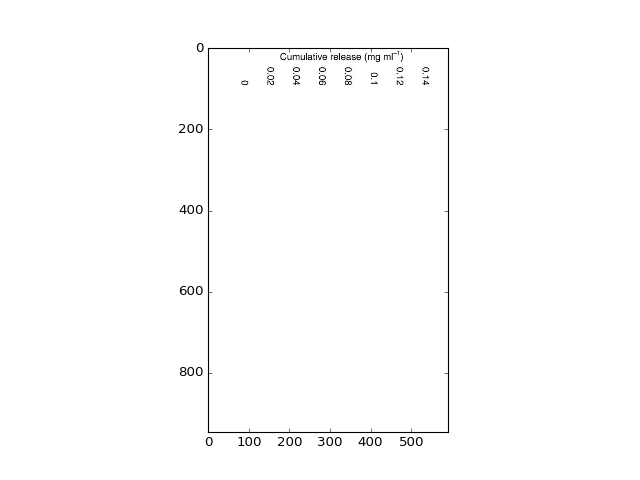

In [65]:
%matplotlib notebook

yTextRot = ndimage.interpolation.rotate(yTextImg, -90)
cv2.imwrite('temp/ytextrot.png',yTextRot)
implot = plt.imshow(yTextRot)
implot.set_cmap('gray')

In [67]:
yRotOcr = tes.image_to_string(Image.open('temp/ytextrot.png'),boxes=True)

### Find the longest "word" and clear its bounding box

In [68]:
yrot_words = ocr_tools.clean_ocr_results(yRotOcr,charspace=10)
word_length = [len(i[0]) for i in yrot_words]
longest_word = np.array(word_length).argmax()
lwbox = yrot_words[longest_word]
lwbox

['Cumulativerelease', 177, 914, 375, 931]

In [69]:
x1 = lwbox[1]-1
y1 = lwbox[2]-1
x2 = lwbox[3]+1
y2 = lwbox[4]+1
y1 = n-y1
y2 = n-y2
yTextRot[y2:y1+1,x1:x2+1,:] = np.ones([y1-y2+1,x2-x1+1,3]).astype('uint8')*255
yText_Clean = ndimage.interpolation.rotate(yTextRot, 90)

<IPython.core.display.Javascript object>


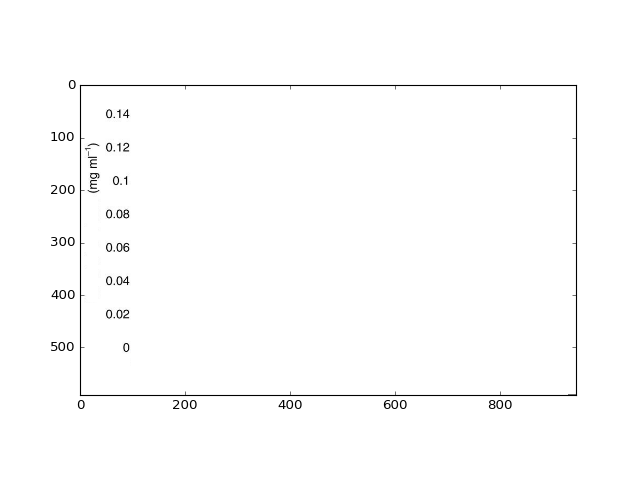

In [70]:
%matplotlib notebook
implot = plt.imshow(yText_Clean)

### Now run conventional OCR

In [74]:
cv2.imwrite('temp/ytextclean.png',yText_Clean)
yocr = tes.image_to_string(Image.open('temp/ytextclean.png'),boxes=True)
yl_ocr = ocr_tools.clean_ocr_results(yocr)
yl_ocr

[['0.14', 50, 526, 94, 543],
 ['A', 15, 473, 37, 478],
 ['0.12', 50, 462, 94, 479],
 ['(', 15, 384, 37, 389],
 ['m', 19, 392, 32, 409],
 ['g', 19, 411, 37, 422],
 ['m', 19, 431, 32, 448],
 ['l', 15, 451, 32, 453],
 ['\xe2\x80\x9c', 9, 454, 20, 469],
 ['0', 63, 399, 74, 416],
 ['0.08', 50, 335, 94, 353],
 ['0.06', 50, 272, 94, 289],
 ['0.04', 50, 209, 94, 226],
 ['0.02', 50, 145, 94, 162]]

In [75]:
yt_numbers = [w for w in yl_ocr if is_number(w[0])]
for w in yt_numbers:
    w[0]=float(w[0])
    w[2] = m-w[2]
    w[4] = m-w[4]
    w.append((w[1]+w[3])/2)
    w.append((w[2]+w[4])/2)
    
yt_label_array = np.array(yt_numbers)
yt_label_array

array([[  1.40000000e-01,   5.00000000e+01,   6.50000000e+01,
          9.40000000e+01,   4.80000000e+01,   7.20000000e+01,
          5.60000000e+01],
       [  1.20000000e-01,   5.00000000e+01,   1.29000000e+02,
          9.40000000e+01,   1.12000000e+02,   7.20000000e+01,
          1.20000000e+02],
       [  0.00000000e+00,   6.30000000e+01,   1.92000000e+02,
          7.40000000e+01,   1.75000000e+02,   6.80000000e+01,
          1.83000000e+02],
       [  8.00000000e-02,   5.00000000e+01,   2.56000000e+02,
          9.40000000e+01,   2.38000000e+02,   7.20000000e+01,
          2.47000000e+02],
       [  6.00000000e-02,   5.00000000e+01,   3.19000000e+02,
          9.40000000e+01,   3.02000000e+02,   7.20000000e+01,
          3.10000000e+02],
       [  4.00000000e-02,   5.00000000e+01,   3.82000000e+02,
          9.40000000e+01,   3.65000000e+02,   7.20000000e+01,
          3.73000000e+02],
       [  2.00000000e-02,   5.00000000e+01,   4.46000000e+02,
          9.40000000e+01,   4.29

<IPython.core.display.Javascript object>


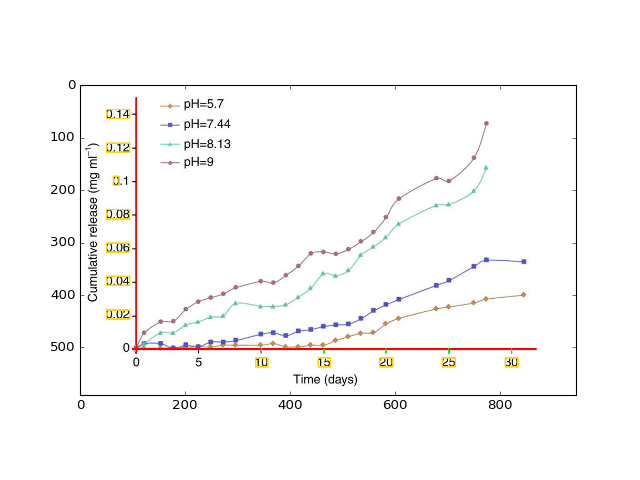

In [76]:
%matplotlib notebook

for w in yt_numbers:
    cv2.rectangle(imlabel, (w[1],w[2]), (w[3],w[4]), (255,215,0), thickness=2, lineType=8, shift=0)

implot = plt.imshow(imlabel)

## Now run the same label/tick matching algorithm for the y-axis

In [77]:
yt_dirty = find_axes.get_yticks(nbw,yax,tickMargin=11,minTickLen=0,maxGap=2)
yt_list=yt_dirty.tolist()

In [78]:
yt_match = find_axes.match_xticks(yt_numbers,yt_list)
yt_pts = [yt_list[i] for i in yt_match]
yt_pts

[[99, 57, 107, 57],
 [99, 122, 107, 122],
 [99, 185, 107, 185],
 [99, 249, 107, 249],
 [99, 313, 107, 313],
 [99, 377, 107, 377],
 [99, 441, 107, 441]]

<IPython.core.display.Javascript object>


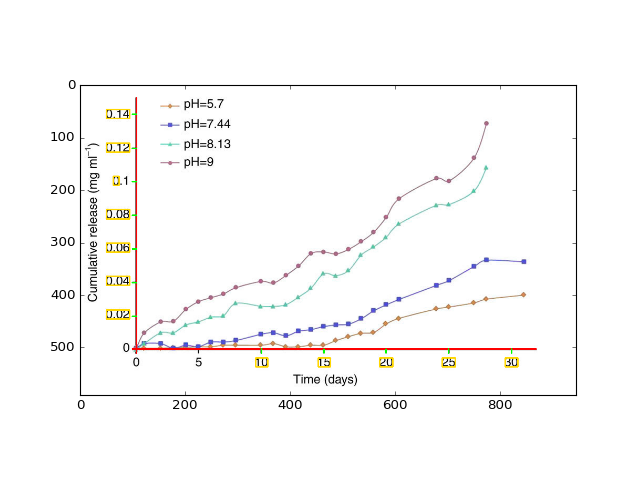

In [79]:
%matplotlib notebook
for x1,y1,x2,y2 in yt_pts:
    cv2.line(imlabel,(x1,y1),(x2,y2),(0,255,0),2)

implot = plt.imshow(imlabel)

In [80]:
yt_pts_array = np.array(yt_pts)
yt_pts_array[:,1].reshape(-1,1)

array([[ 57],
       [122],
       [185],
       [249],
       [313],
       [377],
       [441]])

In [82]:
yt_label_array[:,0].reshape(-1,1)

array([[ 0.14],
       [ 0.12],
       [ 0.  ],
       [ 0.08],
       [ 0.06],
       [ 0.04],
       [ 0.02]])

## Regress the y tick labels

In [83]:
from sklearn import datasets, linear_model
regry = linear_model.LinearRegression(fit_intercept=True)

regry.fit(yt_pts_array[:,1].reshape(-1,1), yt_label_array[:,0].reshape(-1,1))

# The coefficients
print 'Coefficients: \n', regry.coef_
print 'Intercept: \n', regry.intercept_

Coefficients: 
[[-0.00025679]]
Intercept: 
[ 0.12969277]


## Finally, Extract the Data

In [32]:
from color_series_scrape import color_series_scrape

pix_pts, ROI = color_series_scrape(example, [[xax[0],xax[2]]],[[yax[3],yax[1]]], n_colors=4)


KM: fitting model on a small sub-sample of the data
done fitting
KM: Prediciting color indiced on the full image
done predicting
KM: recreating clustered image


[array([[[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],
 
        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],
 
        [[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ..., 
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ]],
 
        ..., 
        [[ 0.98823529,  0.984313

dtype('float64')

In [27]:
from cluster_data import cluster_colorspace_km, return_series

im_recon, im_label = cluster_colorspace_km(ROI[0], 5)
labels_as_ims = return_series(im_label)

%matplotlib notebook
plt.imshow(im_recon)

NameError: name 'ROI' is not defined

<IPython.core.display.Javascript object>


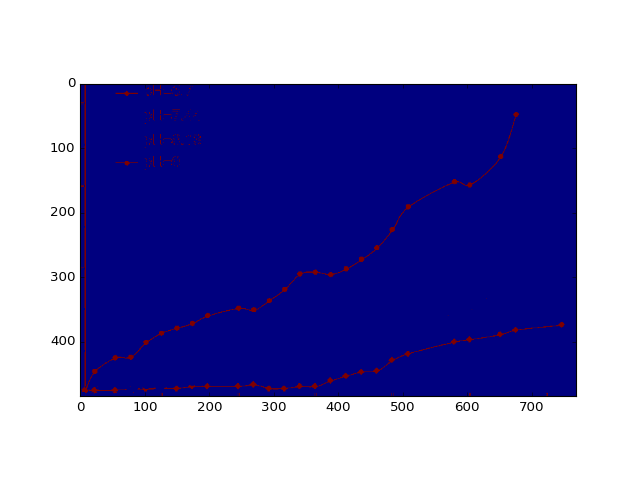

In [87]:
%matplotlib notebook

plt.imshow(labels_as_ims[0])

<IPython.core.display.Javascript object>


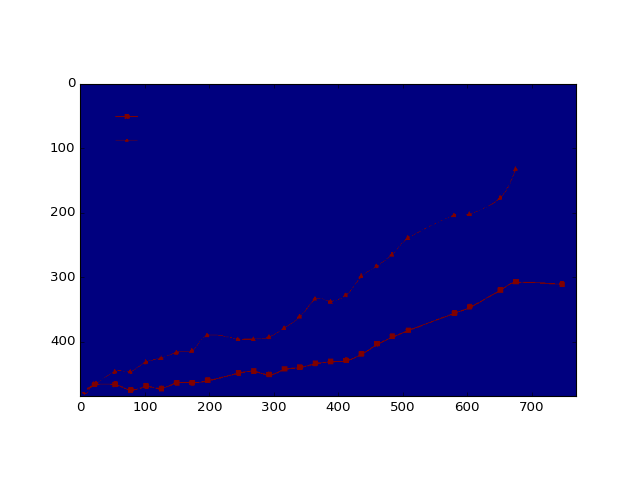

In [88]:
%matplotlib notebook

plt.imshow(labels_as_ims[1])

<IPython.core.display.Javascript object>


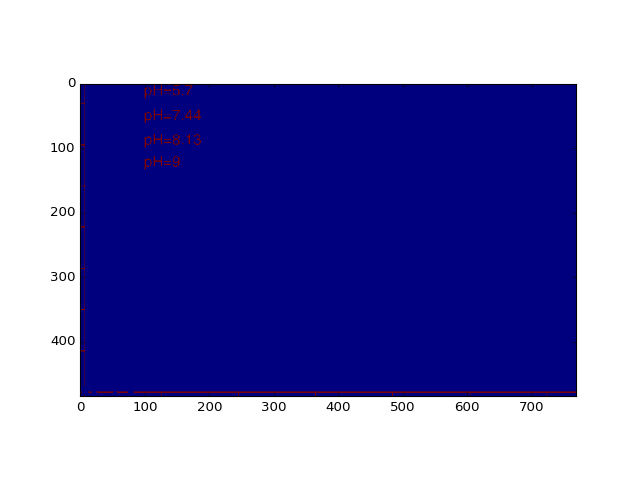

In [89]:
%matplotlib notebook

plt.imshow(labels_as_ims[2])

<IPython.core.display.Javascript object>


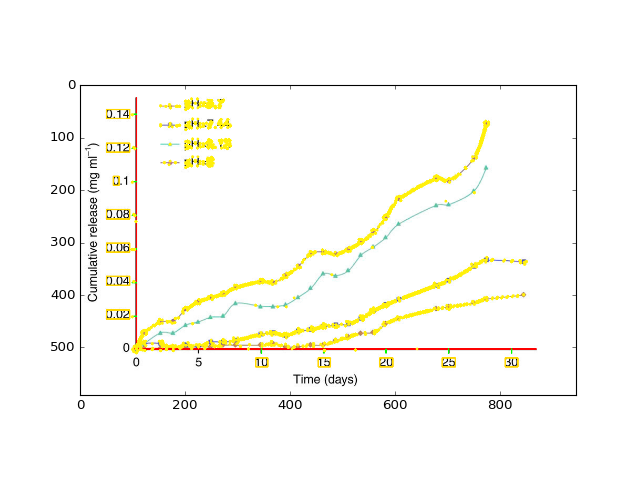

In [90]:
%matplotlib notebook
imlabel4 = imlabel.copy()
pp_list = []
for series in pix_pts[0]:
    s_list = []
    for tup in series:
        x = int(round(tup[1]))+xax[0]
        y = int(round(tup[0]))+yax[3]
        s_list.append([x,y])
    pp_list.append(s_list)

pp_list

for series in pp_list:
    for pt in series:
        cv2.circle(imlabel4,(pt[0],pt[1]), 3, (255,240,10), -1)


lastplot = plt.imshow(imlabel4)

## ... and convert the pixel values to the units of the axes

In [78]:
data_list = []
for series in pp_list:
    ser_list = []
    for pt in series:
        xdata = pt[0]*regrx.coef_+regrx.intercept_
        ydata = pt[1]*regry.coef_+regry.intercept_
        ser_list.append([xdata[0,0],ydata[0,0]])
    data_list.append(ser_list[::-1])

data_list

[[[0.0089784645889228187, 15.737535964271956],
  [0.034223757405993815, 62.919225318847339],
  [0.04824892008214432, 110.10091467342295],
  [0.059469050223064757, 157.28260402799833],
  [0.093129440645826067, 262.13080259372191],
  [0.12398479853335731, 288.34285223515258],
  [0.18289048177318956, 304.07008202001111],
  [0.24179616501302181, 309.31249194829729],
  [0.29789681571762405, 314.55490187658347],
  [0.41851321473251868, 325.03972173315583],
  [0.59803529698724567, 335.52454158972819],
  [0.50827425585988217, 330.28213166144201],
  [0.71584666346691017, 346.00936144630055],
  [0.77194731417151241, 351.25177137458672],
  [0.83085299741134466, 361.73659123115908],
  [0.89256371318640715, 372.22141108773144]],
 [[0.023003627265073379, 178.25224374114305],
  [0.031418724870763692, 298.82767209172493],
  [0.045443887546914252, 450.8575600120239],
  [0.06227408275829488, 592.4026280757505],
  [0.093129440645826067, 807.34143513548338],
  [0.12398479853335731, 933.15927341435145],
  